In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
#import datafeed
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.rcParams.update({'font.size': 16}) 

# Loading up data
#orginal_data = pd.read_excel('data/USA.xls')
orginal_data = pd.read_csv('data/bullionist_controversy//bullionist.csv')

# Seting the horizon as index
orginal_data.rename(columns={list(orginal_data)[0]: 'Year',
                            list(orginal_data)[1]: 'IP', #  Industral Production
                            list(orginal_data)[2]: 'CPI'},
                    inplace=True)
orginal_data.set_index('Year',inplace=True)

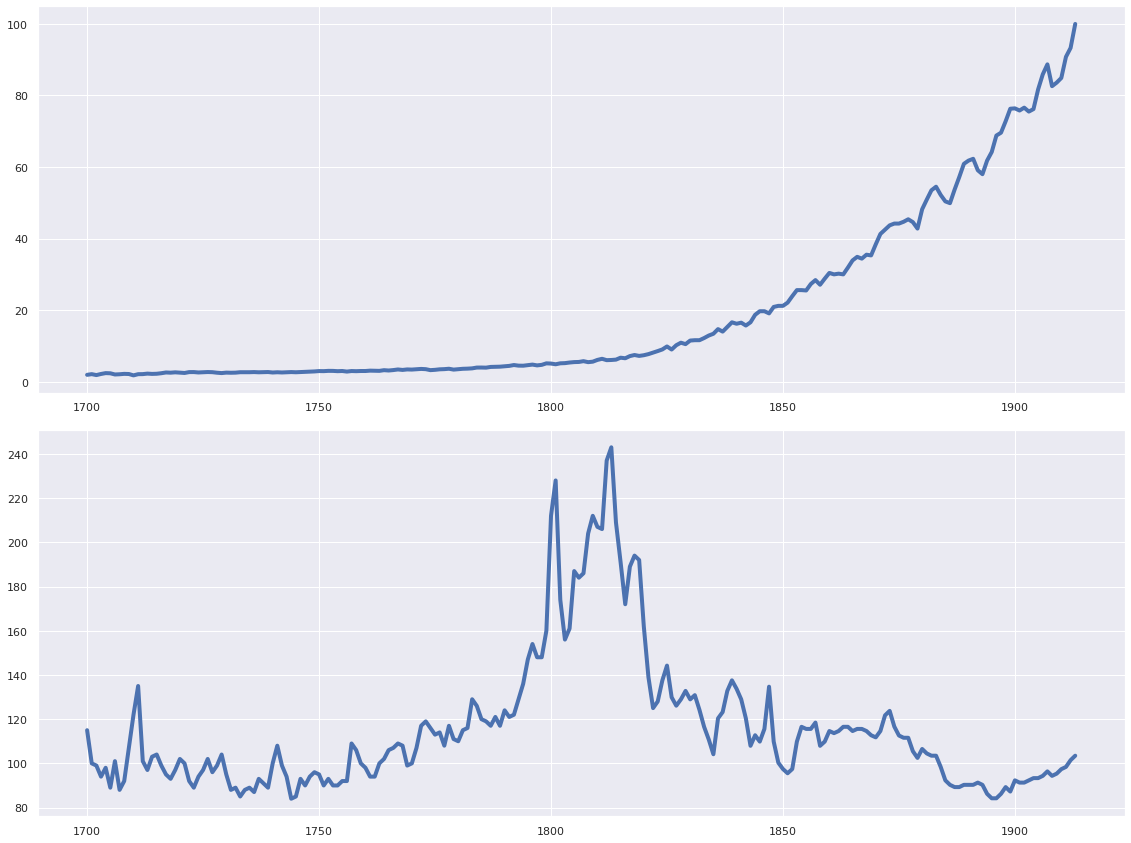

In [4]:
#Data and basic statistics

# Timeseries of IP and CPI
fig1, ax = plt.subplots(2,1,figsize=(4*4,4*3))

ax[0].plot(orginal_data['IP'],lw='4')
ax[1].plot(orginal_data['CPI'],lw='4')

plt.tight_layout()

In [8]:
# IP and CPI transposed as numpy arrays
data = orginal_data.to_numpy()

# Growth rates
#growth_rates = (data[1:,:] - data[:-1,:])/(data[:-1,:])

##---------
## Can also apply log approximation to get growth rates
log1 = np.log(data[1:,:])
log2 = np.log(data[:-1,:])
data_mat = (log1-log2).transpose()
## ---------

In [9]:
# #Detrending
# fig2, ax = plt.subplots(2,1,figsize=(4*4,4*3))

# ax[0].plot(orginal_data['IP'],lw='4')
# ax[1].plot(orginal_data['CPI'],lw='4')

# plt.tight_layout()

In [10]:
# #VAR

# # Model parameters
n = np.size(data_mat,0) # No. of variables
N = np.size(data_mat,1) # No. of observations
p = 6 # Order of VAR
const = 1 # Constant (yes/no)
h = 30 # Forecast horizon

In [11]:
# OLS estimation (Y=A*Z+U)
def VAROLS(data,n,N,p,const):
    Y = data[:,p:]
    Z = np.zeros([n*p,N-p])
    for jj in np.arange(N-p):
        Z[:,jj]= np.reshape(np.fliplr(data[:, jj:jj+p]),
                            n*p,order='F')
    Z = np.concatenate((np.ones((const,N-p)),Z),axis=0)
    
    # A=(Y*Y')*inv(Z*Z')
    A = np.dot(np.dot(Y,Z.T),inv(np.dot(Z,Z.T)))
    
    Sigma = (np.dot(Y,Y.T) - np.dot(A, np.dot(Z,Y.T)))/(N-n*p-const)
    return A, Sigma

A, Sigma = VAROLS(data_mat,n,N,p,const)


print('A matrix\n')
print(A, end='\n\n')
print('Sigma matrix\n')
print(Sigma)

A matrix

[[ 0.02466454 -0.17977756 -0.16013986 -0.18509617 -0.01227251 -0.02087178
  -0.07163293  0.02140098 -0.12846598  0.01650084 -0.00710219  0.02152358
  -0.00674877]
 [ 0.00370338  0.0035608   0.13153262  0.20809894 -0.20068946 -0.14965395
  -0.1375212  -0.23048195 -0.16545404 -0.10435213  0.09269145  0.07190221
  -0.06164289]]

Sigma matrix

[[ 1.80137427e-03 -4.09153083e-05]
 [-4.09153083e-05  3.76860347e-03]]


In [12]:
# VAR(1) representation: Selection (Xi) and companion matrix (J)
def VAR1(A,n,p,const):
    A = A[:, const:]
    
    eye = np.eye(n*(p-1))
    zeros = np.zeros((n*(p-1),n))
    mat = np.concatenate((eye,zeros),axis=1)
    
    Xi = np.concatenate((A,mat),axis=0)
    
    J = np.concatenate((np.eye(n),
                        np.zeros((n,n*(p-1)))),
                       axis=1)
    return Xi, J

Xi, J = VAR1(A,n,p,const)

print('First 3 rows of the Xi matrix\n')
print(Xi[:3,:], end='\n\n')
print('J matrix\n')
print(J)

First 3 rows of the Xi matrix

[[-0.17977756 -0.16013986 -0.18509617 -0.01227251 -0.02087178 -0.07163293
   0.02140098 -0.12846598  0.01650084 -0.00710219  0.02152358 -0.00674877]
 [ 0.0035608   0.13153262  0.20809894 -0.20068946 -0.14965395 -0.1375212
  -0.23048195 -0.16545404 -0.10435213  0.09269145  0.07190221 -0.06164289]
 [ 1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]]

J matrix

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
# Solve identification problem: Blanchard-Quah decomposition
# def BlanchardQuach(n,Xi,J,Sigma):
#     # Reduced form long-run multiplier
#     B1 = np.dot(np.dot(J,inv(np.eye(n*p)-Xi)),J.T)
#     # Structural long-run multiplier
#     temp = np.dot(np.dot(B1,Sigma),B1.T)
#     # Impact matrix
#     C1 = np.linalg.cholesky(temp)
#     S = np.dot(inv(B1),C1)
#     return S, C1

# S, C1 = BlanchardQuach(n,Xi,J,Sigma)

#blanchard_quah: Blanchard-Quah decompostion
# def blanchard_quah(A, Sigma, n, p, const):
#     Xi = VARCompanion(A, const)
#     J = jmat(n, p)
#     B1 = np.dot(np.dot(J, np.linalg.inv(np.eye(n*p)-Xi)), J.T)
#     temp = np.dot(np.dot(B1, Sigma), B1.T)
#     C1 = np.linalg.cholesky(temp)
#     S = np.dot(np.linalg.inv(B1), C1)
#     return S, C1

def BlanchardQuach(Xi,J,Sigma):
    # Reduced form long-run multiplier
    B1 = np.dot(np.dot(J,np.linalg.inv(np.identity(n*p)-Xi)),J.T)
    # Structural long-run multiplier
    temp = np.dot(np.dot(B1,Sigma),B1.T)
    # Impact matrix
    C1 = np.linalg.cholesky(temp)
    S = np.dot(np.linalg.inv(B1),C1)
    return S, C1

S, C1 = BlanchardQuach(Xi,J,Sigma)

print('S matrix\n')
print(S, end='\n\n')
print('C1 matrix\n')
print(C1)

S matrix

[[ 0.03921559  0.01623303]
 [-0.02436728  0.05634571]]

C1 matrix

[[ 0.03645104  0.        ]
 [-0.02363107  0.04201507]]


In [14]:
# Impulse responses
epsilon = np.eye(n)
C = np.zeros((h+1,n,n))

for jj in np.arange(h+1):
    temp1 = np.dot(J, np.linalg.matrix_power(Xi,jj))
    temp2 = np.dot(temp1,J.T)
    temp3 = np.dot(temp2, S)
    C[jj:,:,:] = np.dot(temp3,epsilon)
    
Cs = np.cumsum(C,axis=0)

print('S matrix for h=0 and h=30 respectively\n')
print(Cs[0],'\n\n',Cs[-1])

S matrix for h=0 and h=30 respectively

[[ 0.03921559  0.01623303]
 [-0.02436728  0.05634571]] 

 [[ 3.64504264e-02 -2.23738443e-06]
 [-2.36327213e-02  4.20061057e-02]]


In [15]:
horizon = np.arange(h+1)

# in %
Cs1 = 100*Cs[:,0,0]
Cs2 = 100*Cs[:,0,1]
Cs3 = 100*Cs[:,1,0]
Cs4 = 100*Cs[:,1,1]

pd.DataFrame([Cs1,Cs2,Cs3,Cs4],index=['Cs1','Cs2','Cs3','Cs4']).transpose().head(5)

,Cs1,Cs2,Cs3,Cs4
0,3.921559,1.623303,-2.436728,5.634571
1,3.606768,0.429150,-2.743273,6.381481
2,3.016490,0.154605,-1.479617,5.682481
3,3.074976,0.090264,-1.571269,4.173356
4,3.598379,-0.314792,-2.370971,2.827366


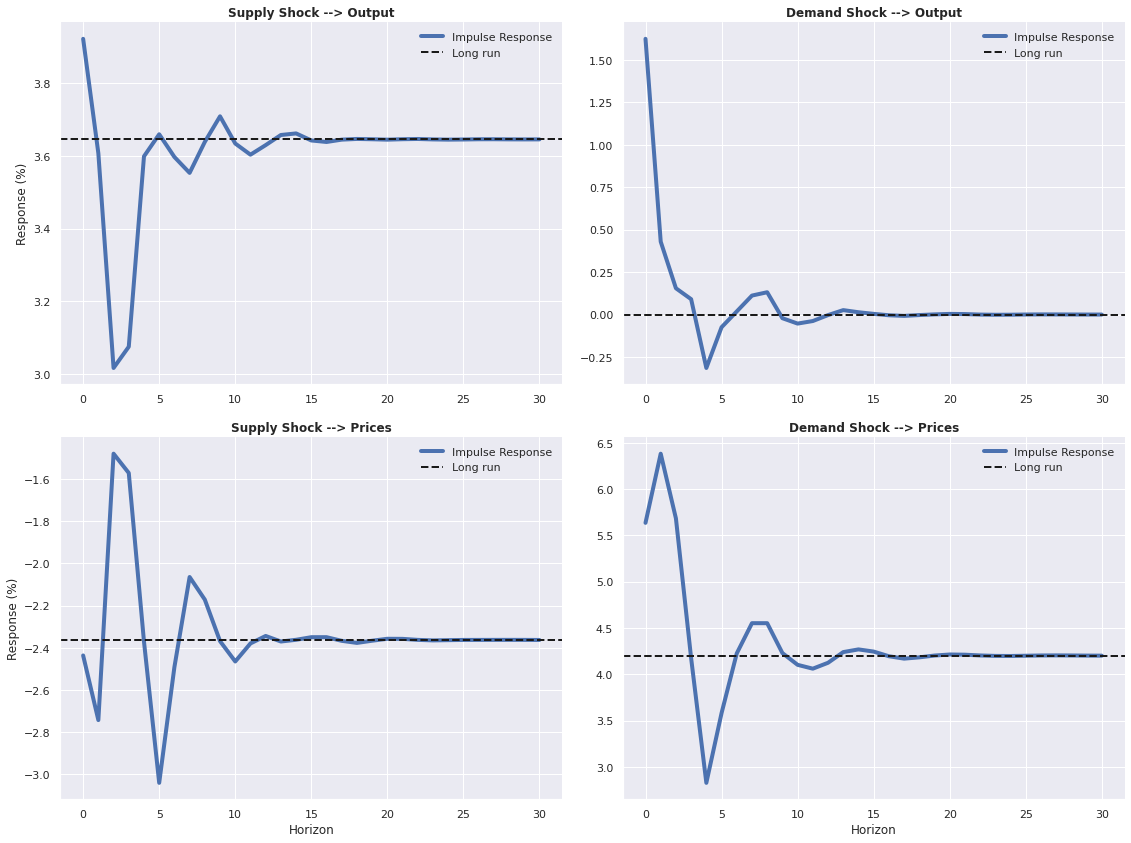

In [16]:
# Plots of impulse responses
shocks = ['Supply Shock','Demand Shock']
# shocks = [r'$\mathrm{\epsilon_S}','Demand Error']
response = ['Output','Prices']

fig3, ax = plt.subplots(2,2,figsize=[4*4,3*4])

ax[0,0].plot(horizon,Cs1,lw='4')
ax[0,0].axhline(y=100*C1[0,0],c='k',lw='2',ls='--')

ax[0,1].plot(horizon,Cs2,lw='4')
ax[0,1].axhline(y=100*C1[0,1],c='k',lw='2',ls='--')

ax[1,0].plot(horizon,Cs3,lw='4')
ax[1,0].axhline(y=100*C1[1,0],c='k',lw='2',ls='--')

ax[1,1].plot(horizon,Cs4,lw='4')
ax[1,1].axhline(y=100*C1[1,1],c='k',lw='2',ls='--')

for i in np.arange(2):
    
    ax[1,i].set_xlabel('Horizon')
    ax[i,0].set_ylabel('Response (%)')
    
    for j in np.arange(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].set_title(shocks[j] + ' --> ' + response[i]
                          ,fontweight='bold')
        ax[i,j].legend(['Impulse Response','Long run'],
                       frameon=False,loc='best')


plt.tight_layout()
#pad=0.4, w_pad=0.5, h_pad=1.0
# filename2 = project_paths('OUT_FIGURES','IR.pdf')
# set(f1,'PaperOrientation','landscape','PaperUnits','normalized','PaperPosition',[0,0,1,1]);
# print(f1,'-dpdf',filename2)

In [17]:
# Forcast Error Variance Decomposition

theta = np.zeros((h+1,n,n))
theta[0,:,:] = (Cs[0,:,:]**2) / np.tile(np.reshape((np.sum(Cs[0,:,:]**2,axis=1)),[n,1]), [1,n])

for jj in np.arange(h):
    # numerator
    theta_numerator = np.sum(Cs[:jj+2,:,:]**2, axis=0)
    # denominator
    d1 = np.transpose(np.sum(Cs[:jj+2,:,:]**2, axis=2))
    d2 = np.transpose(np.array([np.sum(d1, axis=1)]))
    theta_denominator = np.tile(d2, [1,n])
    # final theta
    theta[jj + 1, :, :] = theta_numerator / theta_denominator

# Long-run
theta_long = (C1**2) / np.tile(np.reshape((np.sum(C1**2, axis=1)), [n,1]),[1,n])

In [18]:
theta1 = 100*theta[:,0,0]
theta2 = 100*theta[:,0,1]
theta3 = 100*theta[:,1,0]
theta4 = 100*theta[:,1,1]

pd.DataFrame([theta1,theta2,theta3,theta4],index=['theta1','theta2','theta3','theta4']).transpose().head(5)

,theta1,theta2,theta3,theta4
0,85.371646,14.628354,15.755548,84.244452
1,90.965770,9.034230,15.666731,84.333269
2,92.950160,7.049840,12.998784,87.001216
3,94.273673,5.726327,12.916087,87.083913
4,95.304920,4.695080,15.425840,84.574160


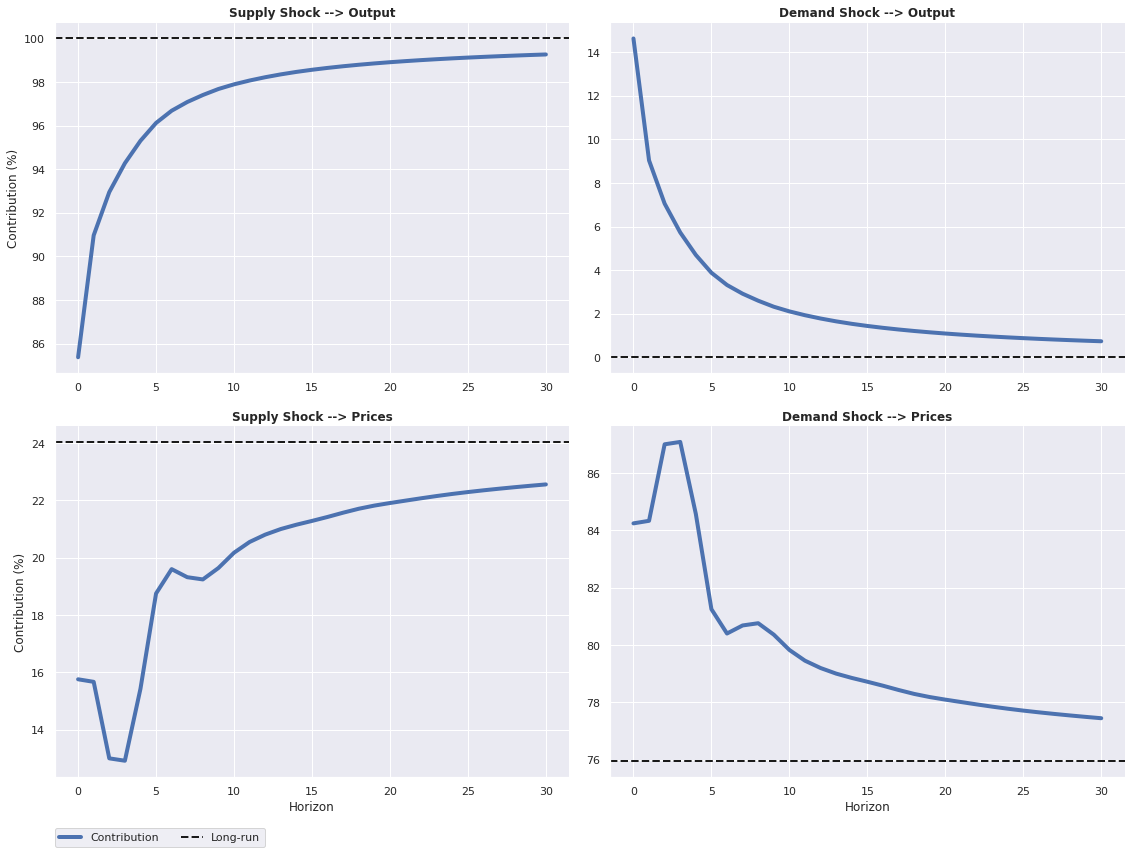

In [19]:
# Plots2

fig4, ax = plt.subplots(2,2,figsize=[4*4,3*4])

# fig2 = plt.figure(figsize=(4*4,3*4))
# ax = fig1.subplots(2,2)

ax[0,0].plot(horizon,theta1,lw='4')
ax[0,0].axhline(y=100*theta_long[0,0],c='k',lw='2',ls='--')

ax[0,1].plot(horizon,theta2,lw='4')
ax[0,1].axhline(y=100*theta_long[0,1],c='k',lw='2',ls='--')

ax[1,0].plot(horizon,theta3,lw='4')
ax[1,0].axhline(y=100*theta_long[1,0],c='k',lw='2',ls='--')

ax[1,1].plot(horizon,theta4,lw='4')
ax[1,1].axhline(y=100*theta_long[1,1],c='k',lw='2',ls='--')

for i in np.arange(2):
    
    ax[1,i].set_xlabel('Horizon')
    ax[i,0].set_ylabel('Contribution (%)')
    
    for j in np.arange(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].set_title(shocks[j] + ' --> ' + response[i]
                          ,fontweight='bold')

        
ax[1,0].legend(['Contribution','Long-run'],loc='lower left', bbox_to_anchor= (0.0, -0.2), ncol=2,borderaxespad=0,frameon=True)
#plt.subplots_adjust(hspace=2)
plt.tight_layout()

In [64]:
# ---OUTPUT---

# Saving figures
#fig1.savefig(fname='Data.pdf',dpi=600)
#fig2.savefig(fname='Trend+Cycle.pdf',dpi=600)
fig3.savefig(fname='ImpulseResponses.pdf',dpi=600)
fig4.savefig(fname='FEVD.pdf',dpi=600)